## __0. Bibliotecas__

In [1]:
# mover os imports para cá

## __1. Datasets__

In [2]:
# carregar todos os datasets aqui

## __2. Pré-processamento dos dados__

Uma vez que vamos trabalhar apenas com pontos no plano cartesiano, precisamos transformar nossos dados em uma **matriz bidimensional**. Para isso, utilizaremos a técnica **SVD** (Singular Value Decomposition) que reduz uma matriz *n*-dimensional em uma matriz *k*-dimensional, onde *k* é o número de fatores latentes. Para nosso trabalho, *k* é sempre 2.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
iris = datasets.load_iris() # apenas o iris tem duas classes linearmente separáveis
digits = datasets.load_digits()
wine = datasets.load_wine()
cancer = datasets.load_breast_cancer()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['Target'] = pd.DataFrame(iris.target)


In [4]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=4, random_state=42)
data_points = svd.fit_transform(df)

In [5]:
df_new = pd.DataFrame(data_points, columns=['x','y'])
df_new['Target'] = pd.DataFrame(iris.target)
df_new

,x,y,Target
0,5.847277,2.461922,0
1,5.511162,2.138145,0
2,5.386715,2.244409,0
3,5.376754,2.035803,0
4,5.810511,2.483696,0
...,...,...,...
145,9.419625,-1.095265,2
146,8.766359,-1.230153,2
147,9.220995,-1.063022,2
148,9.300111,-1.164300,2


## __3. Envoltória Convexa__


#### Implementação do algoritmo de Gift Wrapping(Jarvis March) para determinar as envoltórias das amostras. Este algoritmo possui complexidade $O(nh)$, sendo $n$ o número de pontos e $h$ os pontos que efetivamente estão na envoltória.

In [6]:
# classe para representar pontos bidimensionais no espaço
class Ponto:
    def __init__(self, x, y, rotulo):
        self.x = x
        self.y = y
        self.rotulo = rotulo

In [7]:
#calculando o produto vetorial entre segmentos ab e ac, a = ancora
def produto_vetorial(ancora, b, c):
    return ((b.x-ancora.x)*(c.y-ancora.y) - (c.x-ancora.x)*(b.y-ancora.y))


In [8]:
# encontrando o ponto mais embaixo em relação a y
def mais_a_esquerda(pontos):
    min = 0
    for i in range(1,len(pontos)):
        if pontos[i].y < pontos[min].y:
            min = i
        elif pontos[i].y == pontos[min].y:
            if pontos[i].x < pontos[min].x: # em caso de empate, escolhemos o ponto mais a esquerda
                min = i
    return min

In [9]:
# funcao que recebe um vetor de pontos, e retorna lista com pontos da envoltoria convexa
def gift_wrapping(pontos):
    i_esquerda = mais_a_esquerda(pontos) # guarda indice do ponto mais a esquerda
    p = pontos[i_esquerda]

    prox = (i_esquerda + 1) % len(pontos)

    teste = 0

    envoltoria = [] #incializa envoltoria vazia
    envoltoria.append(p) # adiciona ponto mais à esquerda a envoltoria

    q = p
    while(True):
        # calcula o prox ponto da envoltoria
        while(teste != len(pontos)):
            det = produto_vetorial(q, pontos[prox], pontos[teste])
            if det < 0: # se for negativo, pontos[teste] tem o menor angulo polar,sendo o prox ponto da envoltoria
                prox = teste
            # atualiza teste
            teste = teste+1;

        # se tivermos retornados a ancora, loop acaba
        if p == pontos[prox]:
            break

        # adiciona ponto a envoltoria
        envoltoria.append(pontos[prox])

        # atualiza variáveis
        q = pontos[prox]
        prox = (prox + 1) % len(pontos)
        teste = 0

    # adiciona primeiro ponto ao final da envoltoria para facilitar plot    
    envoltoria.append(p)
    
    return envoltoria

In [10]:
#pontos = [Ponto(x, y) for x, y in data_points]
pontos = [Ponto(x, y, r) for x, y, r in df_new.values]
envoltoria = gift_wrapping(pontos)

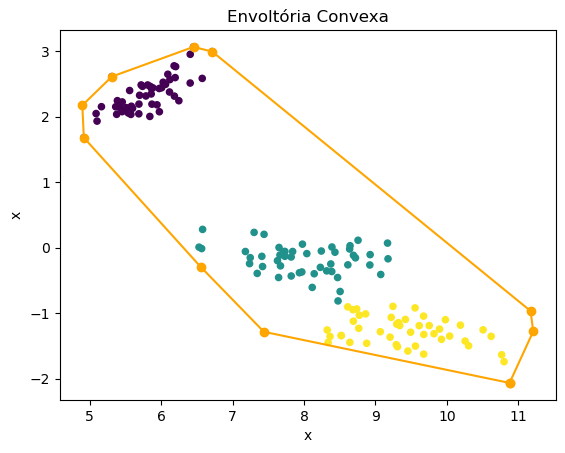

In [11]:
# Criando listas separadas para nomes e idades
Xs1 = [ponto.x for ponto in pontos]
Ys1 = [ponto.y for ponto in pontos]

Xs2 = [ponto.x for ponto in envoltoria]
Ys2 = [ponto.y for ponto in envoltoria]

# Plotando um gráfico de barras
plt.scatter(Xs1, Ys1, c=iris.target, s=20)
plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.xlabel('x')
plt.ylabel('x')
plt.title('Envoltória Convexa')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

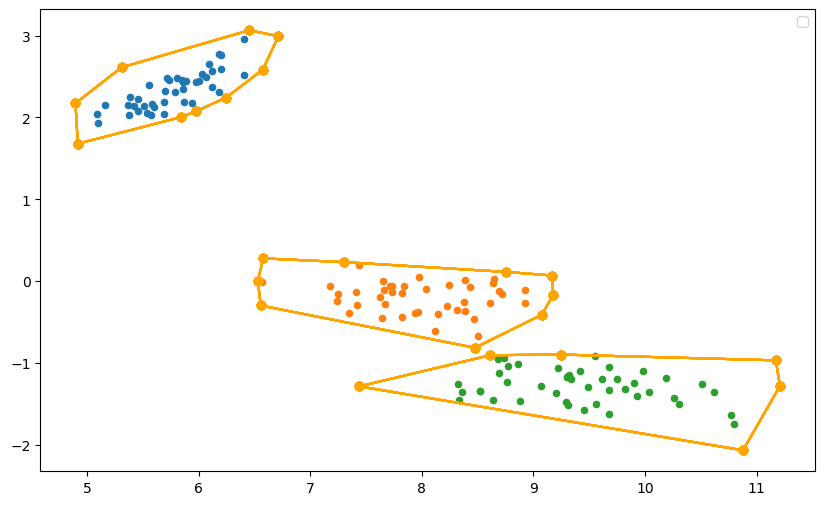

In [12]:
# testando envoltoria com a matriz bidimensional
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']
for i in range(len(names)):
    bucket = df_new[df_new['Target'] == i]
    bucket = bucket.iloc[:,[0,1,2]].values
    bucket_points = [Ponto(x, y, r) for x, y, r in bucket]
    envoltoria[i] = gift_wrapping(bucket_points)
    Xs1 = [ponto.x for ponto in bucket_points]
    Ys1 = [ponto.y for ponto in bucket_points]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria[i]]
    Ys2 = [ponto.y for ponto in envoltoria[i]]
    Xs2.append(envoltoria[i][0].x)
    Ys2.append(envoltoria[i][0].y)
    for j in envoltoria:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()

In [13]:
'''#testando envoltoria com matriz inteira
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
for i in range(len(names)):
    bucket = df[df['Target'] == i]
    bucket = bucket.iloc[:,[2,3,4]].values
    bucket_points = [Ponto(x, y, r) for x, y, r in bucket]
    envoltoria[i] = gift_wrapping(bucket_points)
    Xs1 = [ponto.x for ponto in bucket_points]
    Ys1 = [ponto.y for ponto in bucket_points]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria[i]]
    Ys2 = [ponto.y for ponto in envoltoria[i]]
    Xs2.append(envoltoria[i][0].x)
    Ys2.append(envoltoria[i][0].y)
    for j in envoltoria:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()'''

"#testando envoltoria com matriz inteira\nplt.clf()\nplt.figure(figsize = (10, 6))\nnames = iris.target_names\nlabel = (iris.target).astype(int)\ncolors = ['b','r','g']\nplt.title('Petal Width vs Petal Length')\nplt.xlabel(iris.feature_names[2])\nplt.ylabel(iris.feature_names[3])\nfor i in range(len(names)):\n    bucket = df[df['Target'] == i]\n    bucket = bucket.iloc[:,[2,3,4]].values\n    bucket_points = [Ponto(x, y, r) for x, y, r in bucket]\n    envoltoria[i] = gift_wrapping(bucket_points)\n    Xs1 = [ponto.x for ponto in bucket_points]\n    Ys1 = [ponto.y for ponto in bucket_points]\n    plt.scatter(Xs1, Ys1, s=20)\n    Xs2 = [ponto.x for ponto in envoltoria[i]]\n    Ys2 = [ponto.y for ponto in envoltoria[i]]\n    Xs2.append(envoltoria[i][0].x)\n    Ys2.append(envoltoria[i][0].y)\n    for j in envoltoria:\n        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')\nplt.legend()\nplt.show()"

## __4. Varredura Linear__


#### Implementação da varredura linear para verificação de intercessão de segmentos das envoltórias.


In [14]:
def on_segment(p1, p2, p):
    return min(p1.x, p2.x) <= p.x <= max(p1.x, p2.x) and min(p1.y, p2.y) <= p.y <= max(p1.y, p2.y)

In [15]:
def intersect(p1, p2, p3, p4):
    d1 = produto_vetorial(p3, p4, p1)
    d2 = produto_vetorial(p3, p4, p2)
    d3 = produto_vetorial(p1, p2, p3)
    d4 = produto_vetorial(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and \
        ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False

In [16]:
def any_segment_intersect(envoltoria_1, envoltoria_2):
    n = len(envoltoria_1)
    m = len(envoltoria_2)
    lista_pontos = []
    for i in range(n):
        for j in range(m):
            if intersect(envoltoria_1[i], envoltoria_1[(i + 1) % n], envoltoria_2[j], envoltoria_2[(j + 1) % m]):
                lista_pontos = [envoltoria_1[i], envoltoria_1[(i + 1) % n], envoltoria_2[j], envoltoria_2[(j + 1) % m]]
                return (True, lista_pontos)

    return False

In [17]:
res1 = any_segment_intersect(envoltoria[0], envoltoria[1]) # deve retornar False
res2 = any_segment_intersect(envoltoria[1], envoltoria[2]) # deve retornar True
res3 = any_segment_intersect(envoltoria[0], envoltoria[2]) # deve retornar False

In [18]:
print(res1)
print(res2)
print(res3)

False
False
False


## __5. Algoritmo de varredura para achar pontos mais próximos entre dois conjuntos__


#### __5.2) Algoritmo de varredura__
Este algoritmo tem em seu melhor caso complexiadade $O(n.log(n))$. Em seu pior caso, essa complexidade aumenta para $O(n^2)$. Dada a restrição de que cada ponto do par de pontos retornados precisa ser de um conjunto de pontos diferentes, o parâmetro de distância mínima, usado no algoritmo, tende a ter valores maiores do que se executássemos o algoritmo sem essa restrição. Portanto, espera-se que a complexidade executada esteja entre o caso médio e o pior caso do algoritmo.

In [19]:
import sys
import math

# função que retorna par de pontos rotulados mais próximo entre dois conjuntos de pontos rotulados
def par_mais_proximo(pontos):
    # inicializando variáveis
    p1 = (0,0,0)
    p2 = p1

    # ordena a lista de objetos com base nas coordenadas x dos pontos
    ordenados_X = sorted(pontos, key=lambda obj: obj.x)

    # menor distancia inicializada com valor alto
    min = sys.maxsize

    # criando objeto do tipo conjunto
    st = set()
    # adiciona ponto mais a esquerda ao conjunto
    st.add(ordenados_X[0])

    # varredura sobre pontos ordenados em X
    for i in range(1, len(ordenados_X)):
        # cria conjunto de pontos a esquerda do ponto atual numa distancia no máximo d
        l = set([p for p in st if (p.x >= ordenados_X[i].x - min) and (p.y >= ordenados_X[i].y - min) ])
        # conjunto de pontos a direita do ponto atual a uma distancia no máximo d
        r = set([p for p in st if (p.x <= ordenados_X[i].x + min) and (p.y <= ordenados_X[i].y + min)])
        # intercessao de pontos que podem ter distancia menor que d entre si
        intersection = l & r

        # se não houver pontos com distancias possivelmente menores, passa para o proximo ponto ordenado
        if len(intersection) == 0:
            continue

        # loop sobre a interseção dos conjuntos l e r
        for val in intersection:
            if ordenados_X[i].rotulo == val.rotulo:
                continue

            # Calcula a distância entre os pontos
            dist = math.sqrt(math.pow(ordenados_X[i].x - val.x, 2) + math.pow(ordenados_X[i].y - val.y, 2))

            # Atualiza a distância mínima, se necessário
            if min > dist:
                min = dist
                # guardando o par de pontos mais prox até o momento
                p1 = ordenados_X[i]
                p2 = val

        st.add(ordenados_X[i])

    return p1, p2

## __6. Equação da reta classificadora__


##### Para qualquer equação linear $y = mx + b$, as perpendiculares à ela terão todas uma inclinação de $-1/m$, o recíproco oposto da inclinação original. Para encontrar uma reta perpendicular de um dado segmento $p1p2$, sendo que esta reta também passa por um ponto específico $(x, y)$, nesse caso, a mediana do segmento, basta resolver a equação $y = (-1/m)x + b$, substituindo os valores conhecidos de $m$, $x$ e $y$ para resolver $b$.

In [20]:
# retorna  m e b da equação da reta perpendicular
def reta_perpendicular(p1, p2):
    inclinacao_original = (p1.y-p2.y)/(p1.x-p2.x)

    inclinacao_perpendicular = (-1.0)/inclinacao_original
    # calcula a mediana
    mediana = ((p1.x + p2.x)/2, (p1.y + p2.y)/2) # ponto da mediana

    b = mediana[1] - inclinacao_perpendicular * mediana[0]
    return (b, inclinacao_perpendicular)

# função para calcular os valores y da reta dada um inclinação m e intercessao b
def reta(m, b, x):
    return m * x + b

## __7.Classificador__

In [21]:
def classificar_pontos(P1, P2, pontos):
    b, m = reta_perpendicular(P1, P2)
    labels = []

    for ponto in pontos:
        x, y, r= ponto
        y_na_reta = reta(m, b, x)

        # classifica o ponto com base na posição em relação a reta
        # em datasets que possuem mais de 2 classes, a ideia é inserir como parametro da função, os rotulos
        if y >= y_na_reta:
            labels.append(0)
        elif y < y_na_reta:
            labels.append(1)
        else:
            labels.append(-1) # caso default

    return labels

## __teste dos pontos mais próximos + reta perpendicular__


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

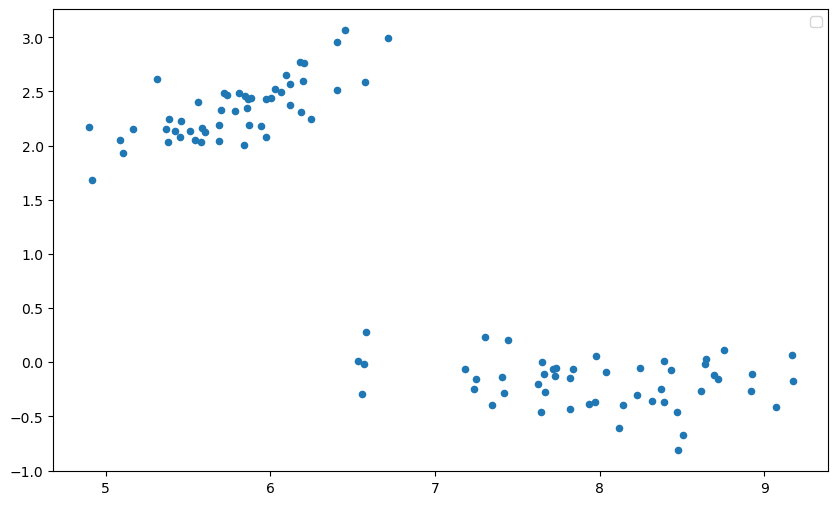

In [22]:
# teste com dois rotulos
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']

#for i in range(len(names)-1):

conjuntoA = df_new[df_new['Target'] == 0]
conjuntoB = df_new[df_new['Target'] == 1]
uniao = [conjuntoA, conjuntoB]
bucket = pd.concat(uniao)
bucket = bucket.iloc[:,[0,1,2]].values
bucket_points = [Ponto(x, y, r) for x, y, r in bucket]

Xs1 = [ponto.x for ponto in bucket_points]
Ys1 = [ponto.y for ponto in bucket_points]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria[i]]
Ys2 = [ponto.y for ponto in envoltoria[i]]
Xs2.append(envoltoria[i][0].x)
Ys2.append(envoltoria[i][0].y)

plt.legend()
plt.show()

In [23]:
p3, p4 = par_mais_proximo(bucket_points)
P3 = Ponto(p3.x, p3.y, p3.rotulo)
P4 = Ponto(p4.x, p4.y, p4.rotulo)

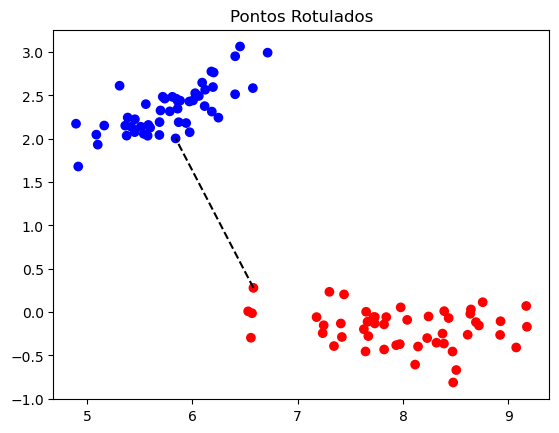

In [24]:
lista_de_objetos = bucket_points
# Cores associadas a cada rótulo
cores = {0: 'blue', 1: 'red'}

# Criando listas de coordenadas e cores
coordenadas_x = [obj.x for obj in lista_de_objetos]
coordenadas_y = [obj.y for obj in lista_de_objetos]
cores_pontos = [cores[obj.rotulo] for obj in lista_de_objetos]

# Plotando os pontos com cores diferentes
plt.scatter(coordenadas_x, coordenadas_y, c=cores_pontos)
# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([P3.x,P4.x], [P3.y,P4.y], 'k--')

# Adicionando legendas e título
plt.title('Pontos Rotulados')

# Exibindo o gráfico
plt.show()


In [25]:
b, m = reta_perpendicular(P3,P4)

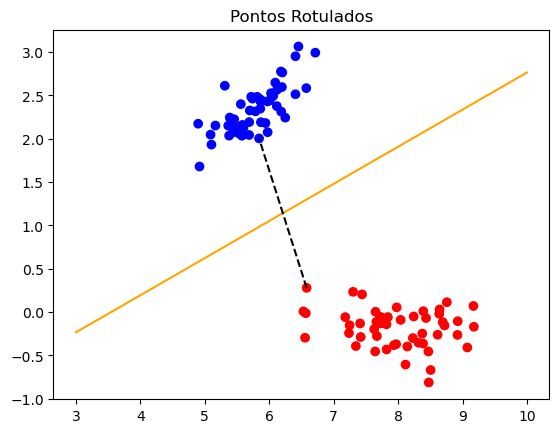

In [26]:
# Gerando valores x para a reta perpendicular
x_valores = np.linspace(3, 10, 50)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Cores associadas a cada rótulo
cores = {0: 'blue', 1: 'red'}

# Criando listas de coordenadas e cores
coordenadas_x = [obj.x for obj in lista_de_objetos]
coordenadas_y = [obj.y for obj in lista_de_objetos]
cores_pontos = [cores[obj.rotulo] for obj in lista_de_objetos]

# Plotando os pontos com cores diferentes
plt.scatter(coordenadas_x, coordenadas_y, c=cores_pontos)
# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([P3.x,P4.x], [P3.y,P4.y], 'k--')

# Adicionando legendas e título
plt.title('Pontos Rotulados')

# Exibindo o gráfico
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

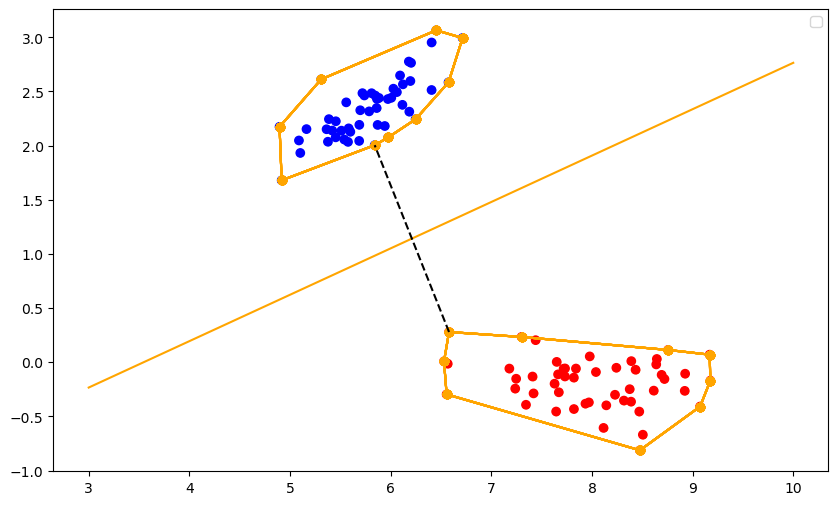

In [27]:
# teste com dois rotulos
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']
for i in range(len(names)-1):
    bucket = df_new[df_new['Target'] == i]
    bucket = bucket.iloc[:,[0,1,2]].values
    bucket_points[i] = [Ponto(x, y, r) for x, y, r in bucket]
    envoltoria[i] = gift_wrapping(bucket_points[i])
    Xs1 = [ponto.x for ponto in bucket_points[i]]
    Ys1 = [ponto.y for ponto in bucket_points[i]]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria[i]]
    Ys2 = [ponto.y for ponto in envoltoria[i]]
    Xs2.append(envoltoria[i][0].x)
    Ys2.append(envoltoria[i][0].y)
    for j in envoltoria:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

uniao = bucket_points[0]+bucket_points[1]
p3, p4 = par_mais_proximo(uniao)
P3 = Ponto(p3.x, p3.y, p3.rotulo)
P4 = Ponto(p4.x, p4.y, p4.rotulo)
b, m = reta_perpendicular(P3,P4)
# Gerando valores x para a reta perpendicular
x_valores = np.linspace(3, 10, 50)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Cores associadas a cada rótulo
cores = {0: 'blue', 1: 'red'}

# Criando listas de coordenadas e cores
coordenadas_x = [obj.x for obj in uniao]
coordenadas_y = [obj.y for obj in uniao]
cores_pontos = [cores[obj.rotulo] for obj in uniao]

# Plotando os pontos com cores diferentes
plt.scatter(coordenadas_x, coordenadas_y, c=cores_pontos)
# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([P3.x,P4.x], [P3.y,P4.y], 'k--')

plt.legend()
plt.show()

## __Breast Cancer Dataset__

### __1.Pré-processamento dos dados__


Fazer k-NN (k-Nearest Neighbors) seguido por t-SNE (t-Distributed Stochastic Neighbor Embedding) em dados serve a diferentes propósitos e está relacionado à análise e visualização de dados em conjuntos de alta dimensionalidade.

__k-NN (k-Nearest Neighbors):__

__Propósito:__ O algoritmo k-NN é usado para encontrar os k vizinhos mais próximos de um ponto em um espaço de características.
Funcionamento: Cada ponto do conjunto de dados é associado aos seus k vizinhos mais próximos. Isso cria uma representação do relacionamento de proximidade entre os pontos no espaço de alta dimensionalidade.
Aplicações: É útil para classificação e regressão, além de fornecer uma noção da densidade e distribuição local dos dados.
t-SNE (t-Distributed Stochastic Neighbor Embedding):

__Propósito:__ O t-SNE é um algoritmo de redução de dimensionalidade não linear que visa preservar as relações de vizinhança entre os pontos em um espaço de alta dimensão.
Funcionamento: Ele mapeia pontos de alta dimensão para um espaço de baixa dimensão de uma maneira que os pontos semelhantes na alta dimensão ainda sejam próximos na baixa dimensão. O t-SNE é especialmente útil para visualizar a estrutura de clusters em dados complexos.
Aplicações: É amplamente utilizado para visualização e interpretação de padrões em dados de alta dimensão.
Motivação para usar ambos:

O k-NN ajuda a identificar padrões locais, enquanto o t-SNE ajuda na visualização dos padrões gerais e na identificação de clusters.
Após o k-NN, você pode ter uma ideia dos relacionamentos locais entre os pontos. A aplicação do t-SNE ajuda a reduzir ainda mais as dimensões, preservando as relações locais em uma representação mais visualmente compreensível.

c:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


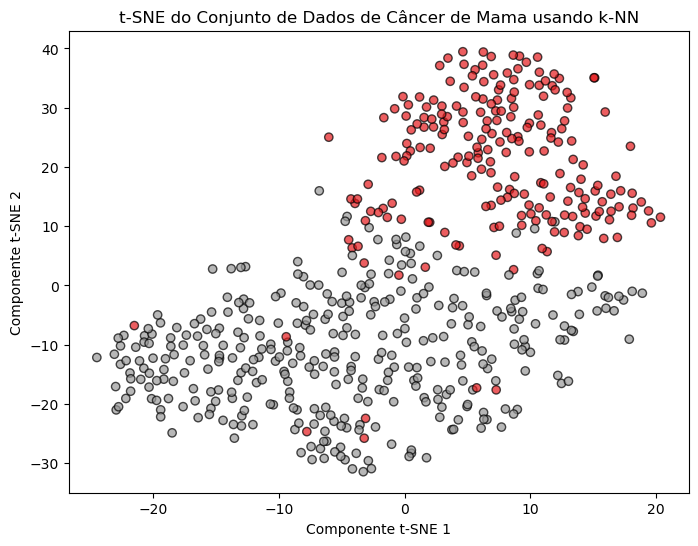

In [28]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Carregar o conjunto de dados de câncer de mama
dados = load_breast_cancer()

# Padronizar os dados
X_padronizado = StandardScaler().fit_transform(dados.data)

# Usar k-NN para encontrar os vizinhos
n_vizinhos = 5
vizinhos = NearestNeighbors(n_neighbors=n_vizinhos)
ajuste_vizinhos = vizinhos.fit(X_padronizado)
distancias, indices = ajuste_vizinhos.kneighbors(X_padronizado)

# Usar t-SNE para redução de dimensionalidade
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_padronizado)

# Adicionar rótulo à matriz de pontos
X_tsne_com_rotulo = np.column_stack((X_tsne, dados.target))

# Plotar os dados reduzidos
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_tsne_com_rotulo[:, 2], cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
plt.title('t-SNE do Conjunto de Dados de Câncer de Mama usando k-NN')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()


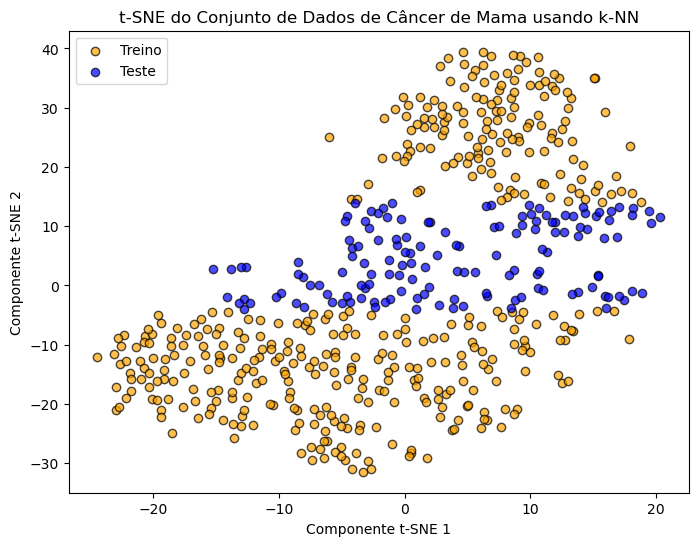

In [29]:

# Adiciona coluna rótulo à matriz de pontos
X_tsne_com_rotulo = np.column_stack((X_tsne, dados.target))

#selecionando dados de treino e removendo outliers
treino = X_tsne_com_rotulo[((X_tsne_com_rotulo[:, 1] < -4) & ~(X_tsne_com_rotulo[:,2] == 0)) | ((X_tsne_com_rotulo[:, 1] > 14)  & ~(X_tsne_com_rotulo[:,2] == 1))]

#selecionando dados de teste
teste = X_tsne_com_rotulo[~(X_tsne_com_rotulo[:, 1] < -4)  & ~(X_tsne_com_rotulo[:, 1] > 14)]

# Plotar os dados reduzidos
plt.figure(figsize=(8, 6))
plt.scatter(treino[:, 0], treino[:, 1], c='orange', label='Treino', cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
plt.scatter(teste[:, 0], teste[:, 1], c='blue', label='Teste', cmap=plt.cm.Set1, edgecolor='k', alpha=0.7)
plt.legend()
plt.title('t-SNE do Conjunto de Dados de Câncer de Mama usando k-NN')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()


Aproximadamente $34\%$ dos dados vão para teste(dados em azul) e $66\%$ para treino(dados em amarelo).

In [30]:
treino_amostra0 = treino[treino[:, 2] == 0]
treino_amostra1 = treino[treino[:, 2] == 1]

### __2.Classificação__

In [31]:
# guardando amostras distintas em listas separadas, e gerando a envoltória de cada uma
amostra0 = [Ponto(x, y, r) for x, y, r in treino_amostra0]
envoltoria_amostra_0 = gift_wrapping(amostra0)

amostra1 = [Ponto(x, y, r) for x, y, r in treino_amostra1]
envoltoria_amostra_1 = gift_wrapping(amostra1)


In [32]:
# Criando listas separadas para pontos e envoltoria
Xs0 = [ponto.x for ponto in amostra0]
Ys0 = [ponto.y for ponto in amostra0]

Xs1 = [ponto.x for ponto in envoltoria_amostra_0]
Ys1 = [ponto.y for ponto in envoltoria_amostra_0]

# Criando listas separadas para pontos e envoltoria
Xs2 = [ponto.x for ponto in amostra1]
Ys2 = [ponto.y for ponto in amostra1]

Xs3 = [ponto.x for ponto in envoltoria_amostra_1]
Ys3 = [ponto.y for ponto in envoltoria_amostra_1]



#### Verificando se envoltórias interceptam:

In [33]:
any_segment_intersect(envoltoria_amostra_0, envoltoria_amostra_1)

False

#### Encontrando o par mais próximo

In [34]:
# juntando amostras
todas_amostras = amostra0 + amostra1

# par mais proximo
p1, p2 = par_mais_proximo(todas_amostras)

# classificando pontos de teste de acordo com modelo
rotulos = classificar_pontos(p1, p2, teste)


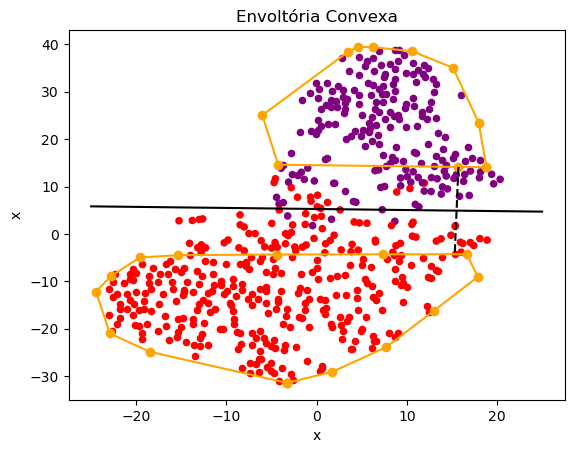

In [35]:
# reta classificadora
b, m = reta_perpendicular(p1,p2)

# Gerando valores x para a reta perpendicular
x_valores = np.linspace(-25, 25, 100)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# Mapeamento de cores (0: azul, 1: vermelho)
cores = np.array(['purple' if v == 0 else 'red' for v in teste[:,2]])

# Criação do gráfico
plt.plot(x_valores, y_valores, color='black')
plt.scatter(Xs0, Ys0, c='purple', label='Rótulo 0', s=20)
plt.scatter(Xs2, Ys2, c='red', label= 'Rótulo 1', s=20)
plt.plot(Xs1, Ys1, linestyle='-', marker='o', color='orange')
plt.plot(Xs3, Ys3, linestyle='-', marker='o', color='orange')
# Plotando os pontos com cores diferentes
plt.scatter(teste[:, 0], teste[:, 1], c=cores, s=20)


# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.xlabel('x')
plt.ylabel('x')
plt.title('Envoltória Convexa')
plt.show()


Métricas de precisão

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular métricas
precisao = precision_score(teste[:, 2], rotulos)
revocacao = recall_score(teste[:, 2], rotulos)
f1 = f1_score(teste[:, 2], rotulos)

# Imprimir os resultados
print(f'Precisão: {precisao}')
print(f'Revocação: {revocacao}')
print(f'F1-escore: {f1}')


Precisão: 0.9487179487179487
Revocação: 0.8505747126436781
F1-escore: 0.896969696969697


## __Date Fruit Dataset__

https://www.muratkoklu.com/datasets/

### __1.Pré-processamento dos dados__

In [53]:
# carregandop arquivo
arquivo_excel = './datasets/Date_Fruit_Datasets.xlsx'

# pegando dados do Excel
data = pd.read_excel(arquivo_excel)

df = pd.DataFrame(data)


In [54]:
# reduzindo dataset para duas classes
df = df[(df['Class'] == 'BERHI') | (df['Class'] == 'SOGAY')]

In [55]:
# Função para mapear os valores da coluna 'class' para 0 ou 1
def rotulo_binario(valor):
    return 0 if valor == 'BERHI' else 1

# atribuindo rotulos binarios para a classe
df['Class'] = df['Class'].apply(lambda x: rotulo_binario(x))


### __2.Classificação__

In [56]:
# Separar as features (x) e a variável de rotulo(y)
Y = df['Class']
X = df.drop(columns=['Class'])

# Padronizar e aplicar o PCA diretamente no DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Adiciona coluna rótulo à matriz de pontos
X_pca = np.column_stack((X_pca, Y.to_numpy()))


In [57]:
# selecionando bases de teste e treino
treino = X_pca[(X_pca[:, 0] < -1.5) | (X_pca[:, 0] > 3)] 
teste = X_pca[~(X_pca[:, 0] < -1.5) & ~(X_pca[:, 0] > 3)] 

#separando as amostras

treino_amostra0 = treino[treino[:, 2] == 0]
treino_amostra1 = treino[treino[:, 2] == 1]


In [58]:
# guardando amostras distintas em listas separadas, e gerando a envoltória de cada uma
amostra0 = [Ponto(x, y, r) for x, y, r in treino_amostra0]
envoltoria_amostra_0 = gift_wrapping(amostra0)

amostra1 = [Ponto(x, y, r) for x, y, r in treino_amostra1]
envoltoria_amostra_1 = gift_wrapping(amostra1)

In [59]:
# Criando listas separadas para pontos e envoltoria
Xs0 = [ponto.x for ponto in amostra0]
Ys0 = [ponto.y for ponto in amostra0]

Xs1 = [ponto.x for ponto in envoltoria_amostra_0]
Ys1 = [ponto.y for ponto in envoltoria_amostra_0]

# Criando listas separadas para pontos e envoltoria
Xs2 = [ponto.x for ponto in amostra1]
Ys2 = [ponto.y for ponto in amostra1]

Xs3 = [ponto.x for ponto in envoltoria_amostra_1]
Ys3 = [ponto.y for ponto in envoltoria_amostra_1]

In [60]:
# verificando intercessao de segmentos
any_segment_intersect(envoltoria_amostra_0, envoltoria_amostra_1)

False

In [61]:
# juntando amostras
todas_amostras = amostra0 + amostra1

# par mais proximo
p1, p2 = par_mais_proximo(todas_amostras)

# classificando pontos de teste de acordo com modelo
rotulos = classificar_pontos(p1, p2, teste)

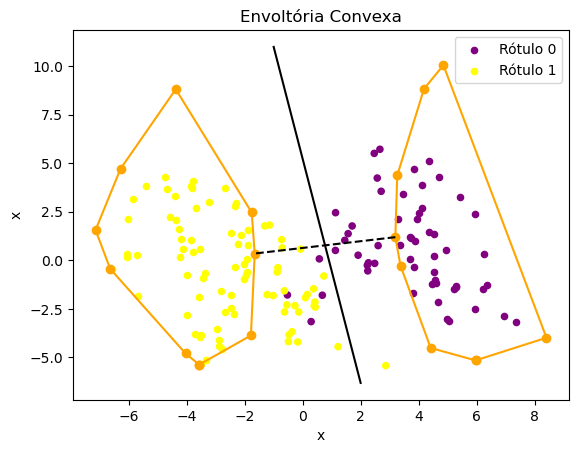

In [63]:

# reta classificadora
b, m = reta_perpendicular(p1,p2)

# Gerando valores x para a reta perpendicular
x_valores = np.linspace(-1, 2, 10)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# Mapeamento de cores (0: azul, 1: vermelho)
cores = np.array(['purple' if v == 0 else 'yellow' for v in teste[:,2]])

# Criação do gráfico
plt.plot(x_valores, y_valores, color='black')
plt.scatter(Xs0, Ys0, c='purple', label='Rótulo 0', s=20)
plt.scatter(Xs2, Ys2, c='yellow', label= 'Rótulo 1', s=20)
plt.plot(Xs1, Ys1, linestyle='-', marker='o', color='orange')
plt.plot(Xs3, Ys3, linestyle='-', marker='o', color='orange')
# Plotando os pontos com cores diferentes
plt.scatter(teste[:, 0], teste[:, 1], c=cores, s=20)


# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([p1.x,p2.x], [p1.y,p2.y], 'k--')
plt.legend()
plt.xlabel('x')
plt.ylabel('x')
plt.title('Modelo de classificação')
plt.show()

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular métricas
precisao = precision_score(teste[:, 2], rotulos)
revocacao = recall_score(teste[:, 2], rotulos)
f1 = f1_score(teste[:, 2], rotulos)

# Imprimir os resultados
print(f'Precisão: {precisao}')
print(f'Revocação: {revocacao}')
print(f'F1-escore: {f1}')


Precisão: 0.8666666666666667
Revocação: 0.9629629629629629
F1-escore: 0.912280701754386


## __Citrus Dataset__

https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit

In [48]:
# carregandop arquivo
arquivo_excel = './datasets/citrus.csv'

# pegando dados do Excel
data = pd.read_csv(arquivo_excel)

df = pd.DataFrame(data)
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [49]:
df= df.sample( frac=1, random_state=42)  # frac=1 significa embaralhar todas as linhas
df = df[:1000]
df

,name,diameter,weight,red,green,blue
6252,grapefruit,10.66,184.37,166,60,18
4684,orange,10.40,181.34,166,109,13
1731,orange,7.99,145.45,150,72,2
4742,orange,10.55,182.99,151,84,2
4521,orange,10.10,177.31,160,72,2
...,...,...,...,...,...,...
3921,orange,9.45,167.78,166,71,4
6685,grapefruit,10.95,189.34,150,82,2
3194,orange,8.91,159.46,185,74,20
1941,orange,8.13,147.57,166,89,21


In [50]:
# Função para mapear os valores da coluna 'class' para 0 ou 1
def rotulo_binario(valor):
    return 0 if valor == 'orange' else 1

# Aplicar a função à coluna 'localidade' e criar uma nova coluna chamada 'rotulo'
df['name'] = df['name'].apply(lambda x: rotulo_binario(x))


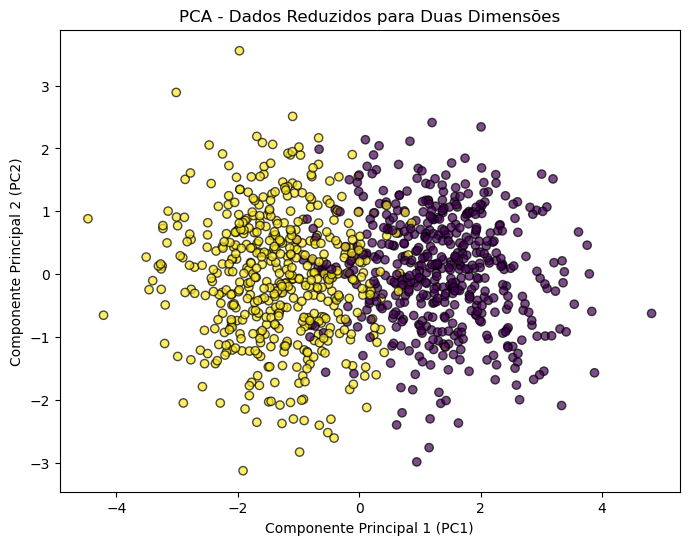

In [51]:
# Separar as features (X) e a variável de destino (y)
Y = df['name']
X = df.drop(columns=['name'])

# Padronizar e aplicar o PCA diretamente no DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Adicionar rótulo à matriz de pontos
X_pca = np.column_stack((X_pca, Y))

# Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 2], cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA - Dados Reduzidos para Duas Dimensões')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.show()

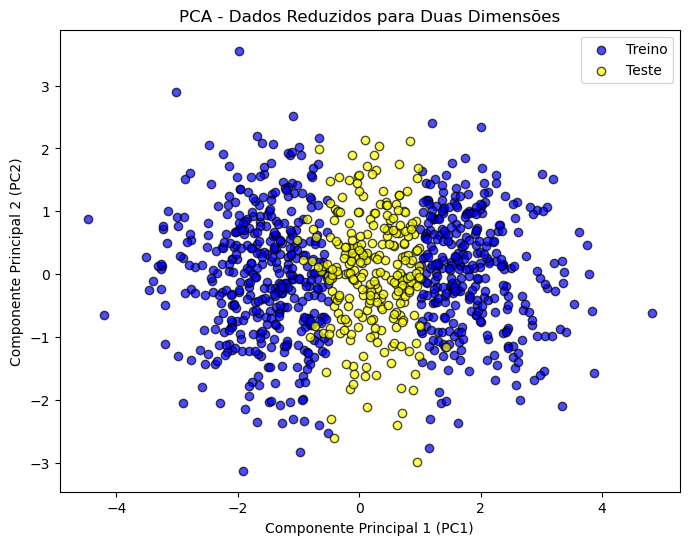

In [52]:
# selecionando dados para treino e teste
treino = X_pca[((X_pca[:,0] < -0.5) & (X_pca[:, 2] == 1)) | ((X_pca[:, 0] > 1) & (X_pca[:, 2] == 0))]
teste = X_pca[~((X_pca[:,0] < -0.5) & (X_pca[:, 2] == 1)) & ~((X_pca[:, 0] > 1) & (X_pca[:, 2] == 0))]

# Visualizar os dados reduzidos para duas dimensões
plt.figure(figsize=(8, 6))
plt.scatter(treino[:, 0], treino[:, 1], c='blue', label='Treino', cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(teste[:, 0], teste[:, 1], c='yellow', label='Teste', cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA - Dados Reduzidos para Duas Dimensões')
# Adicionando legenda
plt.legend()
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.show()

Aproximadamente $35\%$ dos dados serão usados pra teste, e $75\%$ para treino.